### ETAS: NorCal, General Purpose


In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#

import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#

#import ANSStools as atp
from yodiipy import ANSStools as atp
#

import contours2kml
import globalETAS as gep

import global_etas_auto as ggep

from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

failed while loading urllib and/or urllib. maybe python 3.x?


In [3]:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
#to_dt = dtm.datetime(2016,8,25, tzinfo=pytz.timezone('UTC'))
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#
Lr_factor = 10.
# define these from the t_now in the actual etas object, in the event that we load it from pickle,
#  rather than calc it here.
#f_path = '/home/myoder/Dropbox/Research/etas/italy_2016_10/etas_{}'.format(to_dt)
#f_root = 'etas_2016'
#

t0 = dtm.datetime.now(pytz.timezone('UTC'))
t_ms = t0
#
# sacramento:
lat0 = 38.5816
lon0 = -121.4944
ll_sacramento = (lon0, lat0)

#m0 = 7.8

d_lat=5.
d_lon=5.
mc = 1.5
n_cpu = mpp.cpu_count()
#
lats = [lat0-d_lat-1., lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon + 1.]
#to_dt = t0-dtm.timedelta(hours=2)
#to_dt = dtm.datetime.now(pytz.utc)
#
#etas = ggep.auto_etas(to_dt=to_dt, Lr_factor=Lr_factor, dt_0=5)
#italy_prams = {'do_recarray': True, 'D_fract': 1.5,
#                't_0':dtm.datetime(1990, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
#                't_now':to_dt, 
#                'lats': [42.,43.5], 'p': 1.1, 'b1': 1.0, 'mc': 2.5, 'q': 1.5,
#                'lons': [12.,15.], 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
#                'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76}
eq_prams = {'do_recarray': True, 'D_fract': 1.5,
               't_0':dtm.datetime(1980, 1, 1, 0, 0, tzinfo=pytz.timezone('UTC')),
               't_now':to_dt, 't_future':None ,
               'lats': lats, 'p_cat': 1.1, 'b1': 1.0, 'mc': mc, 'q_cat': 1.5,
               'p_etas':1.1, 'q_etas':1.5,
               'lons': lons, 'dmstar': 1.0, 'b2': 1.5, 'd_tau': 2.28,
               'incat': None, 'fit_factor': 2.0, 'd_lambda': 1.76, 'etas_range_padding':1.5,
            'etas_range_factor':30.0, 'ab_ratio_expon':.25 }
#eq_prams.update({'mc':3.0, 'd_lat':.25, 'd_lon':.25})

In [4]:
# get the catalog separately:
# TODO: for some reason, cat_from_anss_comcat() REST API call fails with... mc<=1.0 ???
#
# mycat = atp.cat_from_comcat(lon=lons, lat=lats, minMag=2.5,
# mycat = atp.catfromANSS(lon=lons, lat=lats, minMag=2.5,
#mycat = atp.cat_from_anss_comcat(lon=lons, lat=lats, minMag=mc,
mycat = atp.cat_from_comcat(lon=lons, lat=lats, minMag=mc,
                        dates0=[dtm.datetime(1990,1,1, tzinfo=pytz.timezone('UTC')), 
                                dtm.datetime.now(pytz.timezone('UTC'))],
                            Nmax=None, fout=None, rec_array=True)
#                        dates0=[dtm.datetime(2005,1,1, tzinfo=tzutc), None], Nmax=None, fout=None, rec_array=True)

print('catalog fetched, now process.')
mycat = gep.make_ETAS_catalog_mpp(incat=mycat, n_cpu=n_cpu)
#
print('catalog processed.')
#print('*** DEBUG:\n', mycat[-5:])

catalog fetched, now process.
etas_prams:  {'incat': None, 'lats': [32.0, 38.0], 'lons': [-117.0, -114.0], 'mc': 2.5, 'date_range': ['1990-1-1', None], 'D_fract': 1.5, 'd_lambda': 1.76, 'd_tau': 2.28, 'fit_factor': 1.5, 'p': 1.1, 'q': 1.5, 'dmstar': 1.0, 'b1': 1.0, 'b2': 1.5, 'do_recarray': False}
results fetched.
catalog processed.


In [5]:
n_cpu = 2*mpp.cpu_count()
#n_cpu=5
etas = gep.ETAS_mpp(n_cpu=n_cpu, catalog=mycat, **eq_prams)
#
# we've run this; we can reload it from pickle:
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas = pickle.load(fin)
#
event_name = 'NorCal_general'
f_path = '{}/Dropbox/Research/etas/{}/etas_{}'.format(os.environ['HOME'], event_name, etas.t_now)
f_root = 'etas_{}_2016_11'.format(event_name)

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-10-19 18:53:34.843726+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 373705], None)
make_etas():
etas_mpp worker xyz_range:  [0, 756]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-10-19 18:53:34.843726+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 373705], [0, 756])
etas_mpp worker xyz_range:  [756, 1512]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (3650.000000) = 2009-10-19 18:53:34.843726+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 373705], [756, 1512])
etas_mpp worker xyz_range:  [1512, 2268]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 =

etas complete (from mpp_rtree run() loop); now pipe back([0, 373705])
[9929]: finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 373705])
[9927]: finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 373705])
[9924]: finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 373705])
[9928]: finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 373705])
[9926]: finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 373705])
[9925]: finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 373705])
ETAS complete.


ms:  ('2019-07-06T03:19:53.040000', 35.7695, -117.5993333, 7.1, 8., 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.22684126, 0.08557361], [[ 0.77081566,  0.63705826], [-0.63705826,  0.77081566]], 49127.) -117.5993333 35.7695
tt:  737334.7872088394 1990-01-01T01:03:44.490000 <class 'numpy.datetime64'>


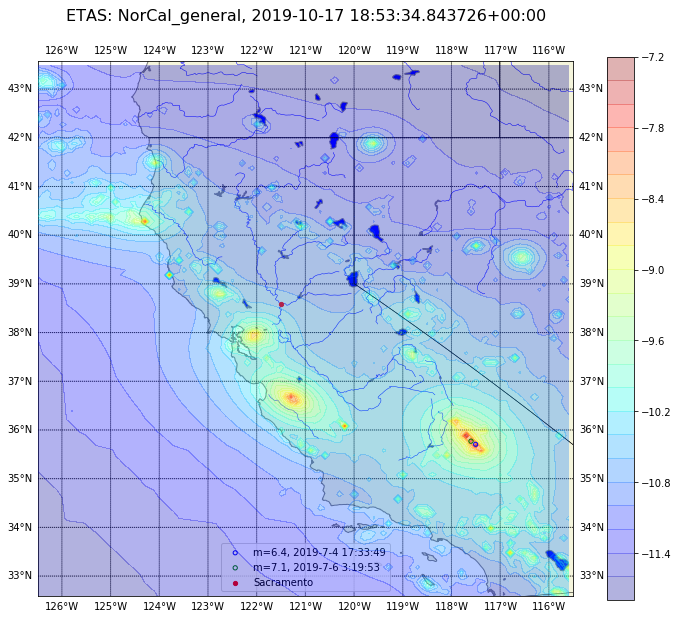

In [6]:
fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax)
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas.catalog[-1]
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 6. 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=180)]
#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(m0, dt_str))

if eq_prams['t_future'] is None:
    ax.set_title('ETAS: {}, {}\n\n'.format(event_name, etas.t_now), size=16)
else:
    ax.set_title('ETAS_cum: {},{}-{}\\n\n\n'.format(event_name, etas.t_now, etas.t_future), size=16)
#
for j,m6 in enumerate(m6s):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=2*(m6['mag']+2.), edgecolors=clr, 
                          c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))

x,y = etas.cm(*ll_sacramento)
etas.cm.scatter([x],[y], marker='o', s=18, edgecolors='r', c='r',
                    label='Sacramento')
t_cat = mpd.date2num(etas.t_now-dtm.timedelta(days=15))
print('tt: ', t_cat, etas.catalog['event_date'][0], type(etas.catalog['event_date'][0]))
k=0

# for j,rw in enumerate(etas.catalog):
#     if mpd.date2num(rw['event_date'].astype(dtm.datetime))<t_cat: continue
#     k+=1
#     clr = colors_[k%len(colors_)]
#     #
#     dt = rw['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     #etas.cm.scatter(rw['lon'],rw['lat'], s=3*(rw['mag']+12.), edgecolors=clr, 
#     #                      c='none', marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str))
#     etas.cm.plot(rw['lon'],rw['lat'], ms=2.*(rw['mag']+2.), color=clr, 
#                           marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str), latlon=True)
    
    #
plt.gca().legend()
#print(etas.catalog[-10:])

In [7]:
print(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5])
len(['{},{}\n'.format(rw['event_date'], rw['mag'] ) for rw in etas.catalog if rw['mag'] >= 5.5
     and rw['event_date'].astype(dtm.datetime)>dtm.datetime(2016,10,20)])



['1990-02-28T23:43:36.750000,5.51\n', '1990-10-24T06:15:19.950000,5.8\n', '1991-06-28T14:43:54.660000,5.8\n', '1991-07-13T02:50:14.690000,6.9\n', '1991-08-16T22:26:14.250000,6.1\n', '1991-08-17T19:29:40.000000,6.0\n', '1991-08-17T22:17:09.970000,7.0\n', '1992-04-23T04:50:23.230000,6.1\n', '1992-04-25T18:06:05.180000,7.2\n', '1992-04-26T07:41:40.090000,6.45\n', '1992-04-26T11:18:25.980000,6.57\n', '1992-06-28T11:57:34.130000,7.3\n', '1992-06-28T12:00:45.000000,5.77\n', '1992-06-28T12:01:16.190000,5.7\n', '1992-06-28T14:43:21.850000,5.53\n', '1992-06-28T15:05:30.730000,6.3\n', '1992-06-29T14:08:37.730000,5.69\n', '1992-07-11T18:14:16.160000,5.67\n', '1993-05-17T23:20:50.250000,6.1\n', '1993-09-21T03:28:55.630000,5.9\n', '1993-09-21T05:45:35.230000,6.0\n', '1994-01-17T12:30:55.390000,6.7\n', '1994-01-17T12:31:58.120000,5.89\n', '1994-01-17T23:33:30.690000,5.58\n', '1994-09-01T15:15:48.310000,7.0\n', '1994-09-12T12:23:43.200000,5.7\n', '1995-02-19T04:03:14.940000,6.6\n', '1995-09-20T23:27:

9

In [8]:
## hey, pickling works with the new ETAS objects (or at least it appears to...):
# with open('data/etas_201610.pkl', 'wb') as fpkl:
#     pickle.dump( etas, fpkl)    
#
#with open('data/etas_201610.pkl', 'rb') as fin:
#    etas2 = pickle.load(fin)
#
#print(etas2.catalog[0:5])
# TODO: we want the datetime part of the filename to come from the etas object itself, for purposes of
# integrity. BUT, we want this script to be a bit more portable, so we should replace all the etas
# references/object name to just 'etas'
#
etas.export_kml(os.path.join(f_path, '{}_{}.kml'.format(f_root, str(etas.t_now).replace(' ', '_'))))
etas.export_xyz(os.path.join(f_path, '{}_{}.xyz'.format(f_root, str(etas.t_now).replace(' ', '_'))))
fg.savefig(os.path.join(f_path, '{}_{}.png'.format(f_root, str(etas.t_now).replace(' ', '_'))))
#
# so this worked, once upon a time, but breaks maybe when the script does not run cleanly all the way through?
#with open (os.path.join(f_path, '{}_{}.pkl'.format(f_root, str(etas.t_now).replace(' ', '_'))), 'wb') as fpkl:
#    pickle.dump(etas, fpkl)


kml bottom, top:  0 23


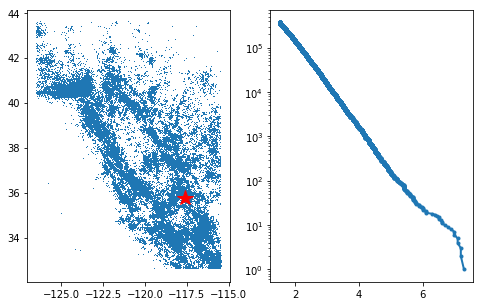

In [9]:
plt.figure(figsize=(8,5))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
ax1.plot(etas.catalog['lon'], etas.catalog['lat'], ',')
ax1.plot([mainshock['lon']], [mainshock['lat']], marker='*', color='r', ms=16, zorder=11)
#
ax2.plot([m for m in reversed(sorted(etas.catalog['mag']))], numpy.arange(1,len(etas.catalog)+1),
         '.-', lw=2.)
ax2.set_yscale('log')

In [10]:
#print(etas.mc, etas.mc_etas)

In [11]:
# plot a cross-section of ETAS. let's get smart about this and do a PCA on the xyz field...
#
#plt.figure()
##my_xy = [[x,y,z] for x,y in zip(etas.catalog['lon'], etas['lat']) if x>=42.25 and x<=42.75]
#my_xyz = [[x,y,z] for x,y,z in etas.ETAS_array if y>=42.25 and y<=42.75]
#plt.figure(figsize=(8,6))
#plt.plot([x for x,y,z in my_xyz ], [z for x,y,z in my_xyz], '.')

In [12]:
mycat = atp.cat_from_comcat(lon=lons, lat=lats, minMag=mc,
                        dates0=[dtm.datetime(1990,1,1, tzinfo=pytz.timezone('UTC')), 
                                dtm.datetime.now(pytz.timezone('UTC'))],
                            Nmax=None, fout=None, rec_array=True)

In [13]:
print(mycat.dtype)

(numpy.record, [('event_date', '<M8[us]'), ('lat', '<f8'), ('lon', '<f8'), ('mag', '<f8'), ('depth', '<f8'), ('event_date_float', '<f8')])


In [14]:
print('sum: ', numpy.sum(etas.ETAS_array['z']))
print(etas.t_forecast, etas.t_future)

sum:  5.670097166105256e-07
737349.7872088394 None


ms:  ('2019-07-06T03:19:53.040000', 35.7695, -117.5993333, 7.1, 8., 737246.13880833, 61.65950019, 1277.03847158, 1.40581446e-05, 18.62087137, 165.68091867, 0.00150686, 1., 1.1, 1.5, 26.80175629, [0.22684126, 0.08557361], [[ 0.77081566,  0.63705826], [-0.63705826,  0.77081566]], 49127.) -117.5993333 35.7695
tt:  737334.7872088394 1990-01-01T01:03:44.490000 <class 'numpy.datetime64'>


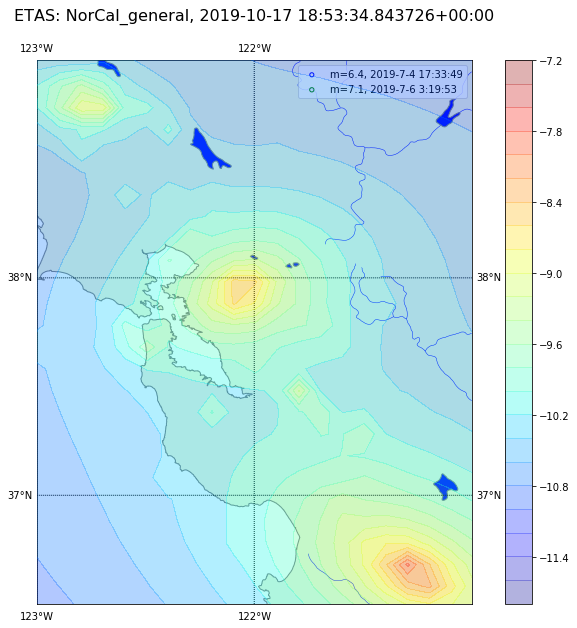

In [15]:
#
# how 'bout a nor-cal zoom in on the Bay Area:
#

fg=plt.figure(0, figsize=(12,10))
ax=plt.gca()
etas.make_etas_contour_map(n_contours=25, fignum=0, map_resolution='f', alpha=.3, ax=ax,
                           lats_map=[36.5, 39.], lons_map=[-123., -121.])
#
#mainshock = sorted(etas.catalog, key=lambda rw: rw['mag'])[-1]
#print('mainshock: ', mainshock)
# get mainshock. it's an m>6 event in the last week or so... this is subjective.
# if we just look for the biggest event, we get the L'Aquila event, so we'll need to be more creative...
# or just specify it.

mainshock = etas.catalog[-1]
for j,eq in enumerate(reversed(etas.catalog)):
    #print('*** ', pytz.utc.localize(eq['event_date'].astype(dtm.datetime)))
    if pytz.utc.localize(eq['event_date'].astype(dtm.datetime))<etas.t_now-dtm.timedelta(days=180): break
    if eq['mag']>mainshock['mag']:
        mainshock = eq
        #
    #
#
print('ms: ', mainshock, mainshock['lon'], mainshock['lat'])
x,y = etas.cm(mainshock['lon'], mainshock['lat'])
#
#print('mm: ', max(etas.catalog['mag']))
#
# let's get everything m>6 in the last 6 months?
m6s = [rw for rw in etas.catalog if rw['mag'] >= 6. 
       and pytz.utc.localize(rw['event_date'].astype(dtm.datetime))>to_dt-dtm.timedelta(days=180)]
#
# plot mainshock:
dt = mainshock['event_date'].astype(dtm.datetime)
dt=t0
dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#etas.cm.plot([x], [y], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(mainshock['mag'], dt_str))
#etas.cm.plot([lon0], [lat0], latlon=False, marker='*', color='r', ms=16, zorder=11,
#                   label='m={}, {}'.format(m0, dt_str))

ax.set_title('ETAS: {}, {}\n\n'.format(event_name, etas.t_now), size=16)
for j,m6 in enumerate(m6s):
    clr = colors_[j%len(colors_)]
    #
    dt = m6['event_date'].astype(dtm.datetime)
    dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    etas.cm.scatter(m6['lon'], m6['lat'], s=2*(m6['mag']+2.), edgecolors=clr, 
                          c='none', marker='o', zorder=11, label='m={}, {}'.format(m6['mag'], dt_str))

x,y = etas.cm(*ll_sacramento)
# etas.cm.scatter([x],[y], marker='o', s=18, edgecolors='r', c='r',
#                     label='Sacramento')
t_cat = mpd.date2num(etas.t_now-dtm.timedelta(days=15))
print('tt: ', t_cat, etas.catalog['event_date'][0], type(etas.catalog['event_date'][0]))
k=0

# for j,rw in enumerate(etas.catalog):
#     if mpd.date2num(rw['event_date'].astype(dtm.datetime))<t_cat: continue
#     k+=1
#     clr = colors_[k%len(colors_)]
#     #
#     dt = rw['event_date'].astype(dtm.datetime)
#     dt_str = '{}-{}-{} {}:{}:{}'.format(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
#     #etas.cm.scatter(rw['lon'],rw['lat'], s=3*(rw['mag']+12.), edgecolors=clr, 
#     #                      c='none', marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str))
#     etas.cm.plot(rw['lon'],rw['lat'], ms=2.*(rw['mag']+2.), color=clr, 
#                           marker='o', zorder=11, label='m={}, {}'.format(rw['mag'], dt_str), latlon=True)
    
    #
plt.gca().legend()
#print(etas.catalog[-10:])

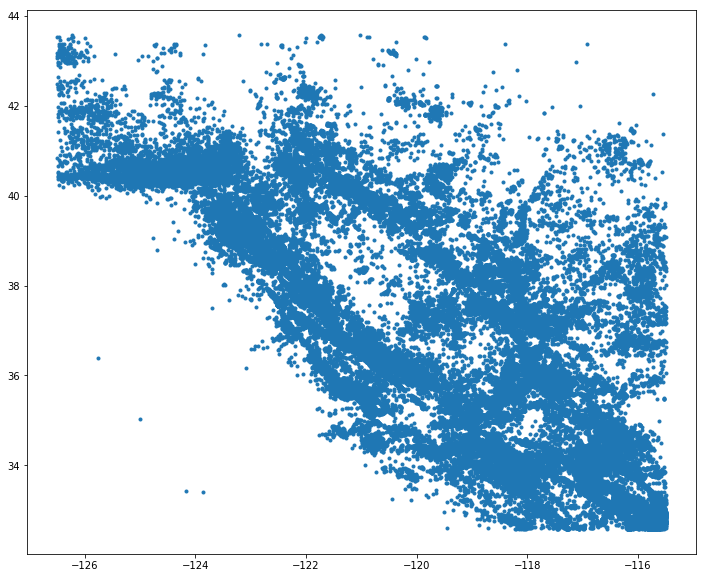

In [16]:
fg = plt.figure(figsize=(12,10))
ax = plt.gca()
#
ax.plot(etas.catalog['lon'], etas.catalog['lat'], marker='.', ls='')

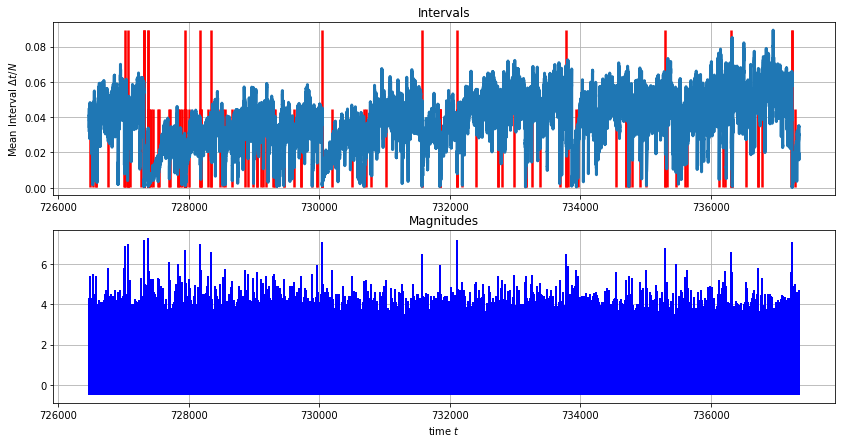

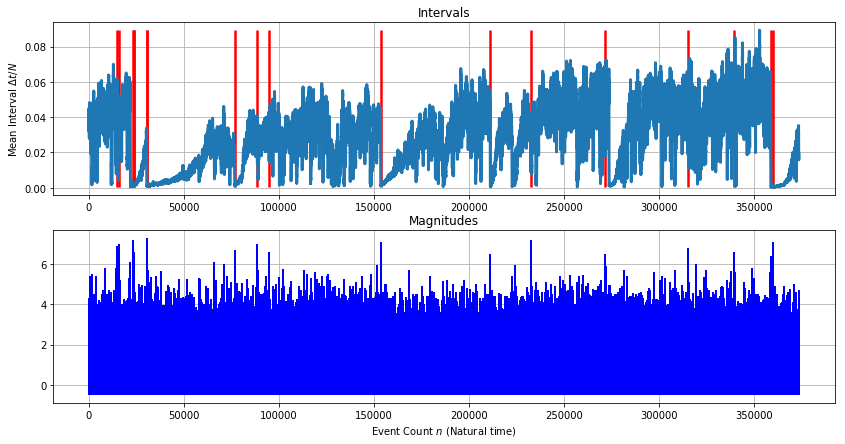

In [17]:
# How 'bout some intervals and magnitudes:
#
# (we should probably build this plot int the class, or really, we should make a separate plotter class, that
#  takes and ETAS object as an input.)
#
fg = plt.figure(figsize=(14,7))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
#
ax1.grid()
ax2.grid()
#
ax1.set_title('Intervals')
ax1.set_ylabel('Mean Interval $\Delta t / N$')
ax2.set_title('Magnitudes')
ax2.set_xlabel('time $t$')
#
n_int = 100
X = etas.catalog['event_date_float']
ix_m = etas.catalog['mag']>6.1
ix_m5 = etas.catalog['mag']>5.0
intervals = numpy.array(X[n_int:] - X[0:-n_int] )/float(n_int)
#
ax1.plot(X[n_int:], intervals, ls='-', lw=3., marker='', label='intervals')
#
ax1.vlines(X[ix_m], min(intervals), max(intervals), color='r', lw=2.5)
ax1.vlines(X[ix_m5], min(intervals), .5*max(intervals), color='r',  lw=2.5)
ax2.vlines(etas.catalog['event_date_float'], etas.catalog['mag'], min(etas.catalog['mag'])-2., color='b', lw=2.)
#ax1.set_xlim(726000)
#
#
#####
fg2 = plt.figure(figsize=(14,7))
ax1 = fg2.add_subplot('211')
ax2 = fg2.add_subplot('212', sharex=ax1)
#
ax1.grid()
ax2.grid()
#
ax1.set_title('Intervals')
ax1.set_ylabel('Mean Interval $\Delta t / N$')
ax2.set_title('Magnitudes')
#
ax2.set_xlabel('Event Count $n$ (Natural time)')
#
ax1.plot(numpy.arange(1, len(intervals)+1), intervals, ls='-', lw=3., marker='', label='intervals')
#
ax1.vlines(numpy.arange(len(etas.catalog))[ix_m], min(intervals), max(intervals), color='r', lw=2.5)
ax2.vlines(numpy.arange(len(etas.catalog)), etas.catalog['mag'], min(etas.catalog['mag'])-2., color='b', lw=2.)
#